In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import typing as t

from pathlib import Path

DATADIR: t.Final[Path] = Path("data/")
MACHINES: t.Final[list[str]] = ["chameleon", "expanse", "faster"]

In [2]:
def process_single_stdout(filename: Path) -> pd.DataFrame:
    records = []
    filtered_lines = []

    with open(filename, "r") as fp:
        lines = fp.readlines()
        flag = False

        for line in lines:
            if flag and line != "\n":
                filtered_lines.append(line)

            if "= slowest durations" in line:
                flag = True
            elif flag and line == "\n":
                flag = False

    filtered_lines = map(lambda line: line.replace("\n", ""), filtered_lines)
    filtered_lines = list(filtered_lines)

    filtered_lines = map(lambda line: line.split(), filtered_lines)
    filtered_lines = list(filtered_lines)

    records = map(
        lambda line: {
            "Runtime": line[0],
            "Type": line[1],
            "Test": line[2],
        },
        filtered_lines,
    )
    records = list(records)

    df = pd.DataFrame.from_records(records)
    df.Runtime = df.Runtime.apply(lambda val: float(val.split("s")[0]))
    df["Machine"] = filename.stem
    return df


def load_data() -> pd.DataFrame:
    return pd.concat(
        [process_single_stdout(DATADIR / f"{machine}.stdout") for machine in MACHINES]
    )

In [3]:
df = load_data()
df["Machine"] = df.Machine.apply(lambda name: name.title())
df["Test"] = df.Test.apply(lambda name: name.split("/")[1])
df["Test"] = df.Test.apply(lambda name: name.replace(".py", ""))
df["Test"] = df.Test.apply(lambda name: name.split("::")[1])
df["Test"] = df.Test.apply(lambda name: name.replace("test_", ""))
df.head()

,Runtime,Type,Test,Machine
0,47.90,call,run,Chameleon
1,20.59,call,parsl_autodock_vina,Chameleon
2,17.55,call,autodock_vina,Chameleon
3,6.33,call,parsl_smi_to_pdb,Chameleon
4,0.65,setup,parsl_smi_to_pdb,Chameleon


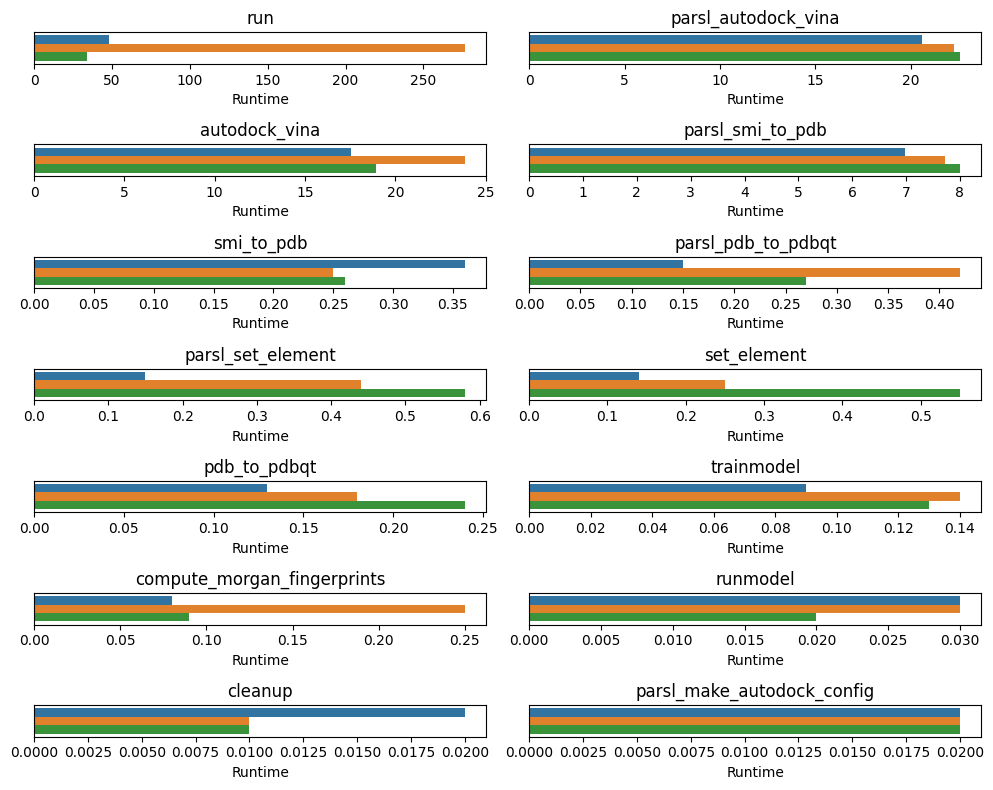

In [4]:
tests = df.Test.unique()

fig, axes = plt.subplots(
    nrows=len(tests) // 2,
    ncols=2,
    figsize=(10, 8),
    sharex=False,
)

i = 0
for axes_i in axes:
    for ax in axes_i:
        t = tests[i]
        sns.barplot(
            df.query("Test == @t"),
            x="Runtime",
            y="Test",
            hue="Machine",
            estimator="sum",
            errorbar=None,
            ax=ax,
        )
        ax.set(xscale="linear")
        ax.get_legend().remove()
        ax.set_ylabel("")
        ax.set_title(t)
        ax.set_yticks([])
        i += 1

# plt.legend(
#     loc="upper center",
#     bbox_to_anchor=(0.4, 1.2),
#     ncols=3,
#     frameon=False,
# )

plt.tight_layout()
plt.show()

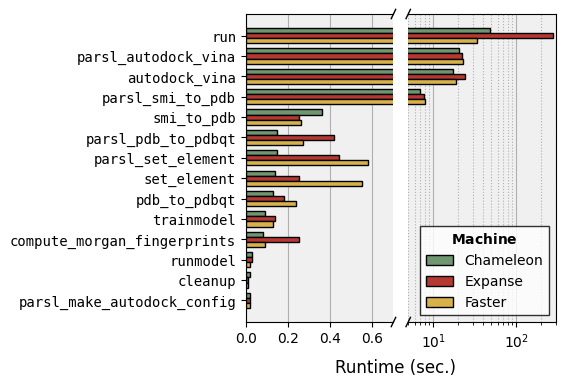

In [ ]:
fig, axes = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(4, 4),
)

gruvbox = sns.color_palette(
    [
        "#689d6a",
        "#cc241d",
        "#eebd35",
    ]
)

for ax in axes:
    sns.barplot(
        df,
        x="Runtime",
        y="Test",
        hue="Machine",
        estimator="sum",
        errorbar=None,
        zorder=3,
        edgecolor="black",
        width=0.75,
        palette=gruvbox,
        ax=ax,
    )
    ax.set_facecolor("#f0f0f0")
    ax.grid(linestyle="-", axis="x", which="major", zorder=0)
    ax.grid(linestyle=":", axis="x", which="minor", zorder=0)
    ax.set_xlabel("")
    ax.set_ylabel("")

######################################################################

ax = axes[0]
ax.set_xlim(0, 0.7)
ax.set(xscale="linear")
ticks = [0.0, 0.2, 0.4, 0.6]
ax.set_xticks(ticks, ticks)
ax.spines.right.set_visible(False)
ax.get_legend().remove()
ax.tick_params(axis="y", labelfontfamily="monospace")

ax = axes[1]
ax.set_yticks([])
ax.set_yticklabels([])
ax.set_xlim(5, 300)
ax.set(xscale="log")
ax.spines.left.set_visible(False)

sns.move_legend(
    ax,
    "lower right",
    title=r"$\bf{Machine}$",
    # frameon=False,
    fancybox=False,
    edgecolor="black",
)

######################################################################

d = 0.015  # how big to make the diagonal lines in axes coordinates
# arguments to pass plot, just so we don't keep repeating them
kwargs = dict(
    transform=axes[0].transAxes,
    color="k",
    clip_on=False,
    linewidth=1,
)
axes[0].plot((1 - d, 1 + d), (-d, +d), **kwargs)
axes[0].plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)

kwargs.update(transform=axes[1].transAxes)  # switch to the bottom axes
axes[1].plot((-d, +d), (1 - d, 1 + d), **kwargs)
axes[1].plot((-d, +d), (-d, +d), **kwargs)

######################################################################

fig.supxlabel("Runtime (sec.)", y=-0.025)

# plt.setp()
plt.subplots_adjust(
    # left=0.1,
    # right=0.9,
    # top=0.9,
    # bottom=0.1,
    wspace=0.1,
    # hspace=4,
)
plt.savefig("figure/test_runtimes.pdf", bbox_inches="tight")
plt.show()